In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from copy import deepcopy
import glob
import sys

[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import DataStruct
from plotting_utils import figSize
from session_utils import *
from recalibration_utils import *
from sklearn.linear_model import LinearRegression
from CosineTuning import angle_between

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
new_sessions = glob.glob('D:/T5_ClosedLoop/new/*')

for i, session in enumerate(new_sessions):
    if i > 15:
        print('Attempting..... ', session)
        try:
            dat = DataStruct(session)
        except:
            print('Loading FAILED!')
        print('-' * 100)

Attempting.....  D:/T5_ClosedLoop/new\t5.2021.07.12.mat
----------------------------------------------------------------------------------------------------
Attempting.....  D:/T5_ClosedLoop/new\t5.2021.07.14.mat
----------------------------------------------------------------------------------------------------
Attempting.....  D:/T5_ClosedLoop/new\t5.2021.07.19.mat
----------------------------------------------------------------------------------------------------
Attempting.....  D:/T5_ClosedLoop/new\t5.2021.07.26.mat
----------------------------------------------------------------------------------------------------


### Check behavior and neural activity (offline)

Checking behavior....


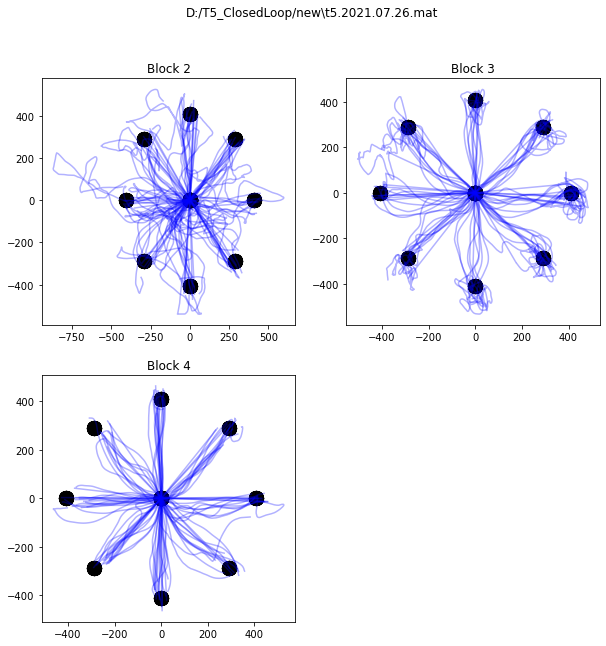

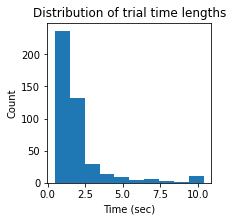

----------------------------------------------------------------------------------------------------
Checking neural....
Angle between X, Y-velocity decoding subspaces: 93.2  degrees
R^2 score on holdout set:  0.373


In [25]:
dat = DataStruct(new_sessions[-1])

print('Checking behavior....')
nPanels = np.ceil(len(dat.blockList) ** 0.5).astype('int')
figSize(5 * nPanels, 5 * nPanels)

plt.suptitle(new_sessions[-1])
for i, block in enumerate(dat.blockList):
    plt.subplot(nPanels, nPanels, i + 1)
    for j in np.where(dat.blockNums == block)[0]:
        _ = plt.scatter(dat.targetPos[j][0, 0], dat.targetPos[j][0, 1], color = 'k', s = 200)
        _ = plt.plot(dat.cursorPos[j][:, 0], dat.cursorPos[j][:, 1], color = 'b', alpha = 0.3)
    plt.title('Block ' + str(block))

plt.figure(2)

plt.subplot(3, 3, 1)
trlens = dat.trialEpochs[:, 1] - dat.trialEpochs[:, 0]
_ = plt.hist(trlens / 50)
plt.xlabel('Time (sec)')
plt.ylabel('Count')
plt.title('Distribution of trial time lengths')
plt.show()
print('-' * 100)
print('Checking neural....')


train_size = 0.5
task       = None
sigma      = 2

# -------------------------------------------------

train_x, test_x, train_y, test_y  = getTrainTest(dat, train_size = train_size, sigma = sigma, task = task, blocks = None, returnFlattened = True)
train_x, test_x                   =  get_BlockwiseMeanSubtracted(train_x, test_x, concatenate = True)

# combine other trial data across blocks:
train_y      = np.concatenate(train_y)
test_y       = np.concatenate(test_y)

means        = train_x.mean(axis = 0)
veldecoder   = LinearRegression(normalize = False).fit(train_x, train_y)
XY_dec_angle = angle_between(veldecoder.coef_[0, :], veldecoder.coef_[1, :])  # angle between X-velocity and Y-velocity decoder 

print('Angle between X, Y-velocity decoding subspaces:', np.round(XY_dec_angle * 180 / np.pi, 1), ' degrees')
print('R^2 score on holdout set: ', np.round(veldecoder.score(test_x, test_y), 3))

### Notes

*t5.2021.04.26* - used blocks [5, 6, 7]; all blocks are good

*t5.2021.04.28* - used blocks [2, 4, 5]; block 2 (first CL) is super noisy

*t5.2021.05.03* - used blocks [5]; block is kk (lower than average performance but fine) 

*t5.2021.05.05* - used blocks [3, 4, 5]; blocks seem fine

*t5.2021.05.17* - used blocks [2, 3, 4]; blocks seem fine (little bit meh)

*t5.2021.05.19* - used blocks [1, 2]; blocks seem fine (little bit meh)

*t5.2021.05.24* - used blocks [2, 3, 4]; blocks seem fine; block 4 had error recording successful clicks toward end (trials ended and targets changed color but wasnt recorded)

*t5.2021.05.26* - used blocks [1, 2, 3]; blocks seem fine

*t5.2021.06.02* - used blocks [2, 3, 4]; blocks seem fine

In [17]:
sessions_check              = dict()
sessions_check['bad_days']  = []
#sessions_check['D:/T5_ClosedLoop/new\\t5.2021.05.17.mat'] = None
np.save('../misc_data/NewSessions_check.npy', sessions_check)

### check across-day generalizability

In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from copy import deepcopy
import glob, sys

[sys.path.append(f) for f in glob.glob('utils/*')]
from preprocess import *
from firingrate import raster2FR
from plotting_utils import *
from lineplots import plotsd
from hmm_utils import *
from hmm import *
from stabilizer_utils import *
from recalibration_utils import *
from session_utils import *

dataset        = 'new'   # if 'old' loads historical T5 cursor data; if 'new' loads the recent May 2021 - onward recordings
min_nblocks    = 3
max_ndays      = 60
min_R2         = -1

if dataset == 'old':
    sessions_check = '../misc_data/OldSessions_check.npy'
    dataset_dir    = 'D:/T5_ClosedLoop/historical/*'
elif dataset == 'new':
    sessions_check = '../misc_data/NewSessions_check.npy'
    dataset_dir    = 'D:/T5_ClosedLoop/new/*'
else:
    assert False, "<dataset> arg not recognized"

sessions_check = np.load(sessions_check, allow_pickle = True).item()
files          = get_Sessions(glob.glob(dataset_dir), min_nblocks, manually_remove = sessions_check['bad_days'])
pairs          = get_SessionPairs(files, max_ndays = max_ndays)
#pairs, scores  = get_StrongTransferPairs(pairs, min_R2 = min_R2, train_frac = 0.5, block_constraints = sessions_check)
n_pairs        = len(pairs)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
block_constraints = sessions_check
train_size        = 0.67
task              = None
sigma             = 2


for i, (A_file, B_file) in enumerate(pairs):
    dayA      = DataStruct(A_file)
    dayB      = DataStruct(B_file)

    dayA_blocks, dayB_blocks = None, None
    
    Atrain_x, Atest_x, Atrain_y, Atest_y  = getTrainTest(dayA, train_size = train_size, sigma = sigma, blocks = dayA_blocks, task = task, returnFlattened = True)    
    Atrain_x, Atest_x  = get_BlockwiseMeanSubtracted(Atrain_x, Atest_x, concatenate = True)
    Atrain_y           = np.concatenate(Atrain_y)
    Atest_y            = np.concatenate(Atest_y)
    
    Btrain_x, Btest_x, Btrain_y, Btest_y  = getTrainTest(dayB, train_size = train_size, sigma = sigma, blocks = dayB_blocks, task = task, returnFlattened = True)    
    Btrain_x, Btest_x  = get_BlockwiseMeanSubtracted(Btrain_x, Btest_x, concatenate = True)
    Btrain_y           = np.concatenate(Btrain_y)
    Btest_y            = np.concatenate(Btest_y)
    
    #A_score, A_decoder    = traintest_DecoderSupervised([Atrain_x], [Atest_x], [Atrain_y], [Atest_y], meanRecal = False)           # evaluate training set mean performance 
    #B_score, B_decoder    = traintest_DecoderSupervised([Btrain_x], [Btest_x], [Btrain_y], [Btest_y], meanRecal = False) 

    lm        = LinearRegression(fit_intercept = True, normalize = False).fit(Atrain_x, Atrain_y)
    score     = lm.score(Btest_x, Btest_y)
    print('Reference: ', dayA.date)
    print('New: ', dayB.date)
    print('R2 score (mean recal): ', score)

Reference:  2021.04.26
New:  2021.04.28
R2 score (mean recal):  -0.08492415413669413
Reference:  2021.04.26
New:  2021.05.05
R2 score (mean recal):  -0.13676773408805182
Reference:  2021.04.26
New:  2021.05.17
R2 score (mean recal):  -0.045893674896807624
Reference:  2021.04.26
New:  2021.05.24
R2 score (mean recal):  -0.02054559806661377
Reference:  2021.04.26
New:  2021.05.26
R2 score (mean recal):  -0.016236050457467455
Reference:  2021.04.26
New:  2021.06.02
R2 score (mean recal):  0.08315887690253992
Reference:  2021.04.28
New:  2021.05.05
R2 score (mean recal):  0.10100020528502318
Reference:  2021.04.28
New:  2021.05.17
R2 score (mean recal):  0.1601382953521972
Reference:  2021.04.28
New:  2021.05.24
R2 score (mean recal):  -0.04442919572439863
Reference:  2021.04.28
New:  2021.05.26
R2 score (mean recal):  -0.23999104741077332
Reference:  2021.04.28
New:  2021.06.02
R2 score (mean recal):  0.05286272329557745
Reference:  2021.05.05
New:  2021.05.17
R2 score (mean recal):  0.18

In [49]:
from CosineTuning import fitEncodingMatrix
from sklearn.linear_model import Ridge

train_size = 0.67
sigma      = 2


nFiles  = len(files)
dates   = list()
weights = list()
for i, file in enumerate(files):
    session = DataStruct(file)
    dates.append(session.date)

    train_x, test_x, train_y, test_y  = getTrainTest(session, train_size = train_size, sigma = sigma, blocks = None, task = None, returnFlattened = True)    
    train_x, test_x   = get_BlockwiseMeanSubtracted(train_x, test_x, concatenate = True)
    train_y           = np.concatenate(train_y)
    test_y            = np.concatenate(test_y)
    lm        = Ridge(fit_intercept = False, normalize = False, alpha = 0).fit(train_x, train_y)
   # lm        = LinearRegression(fit_intercept = False, normalize = False).fit(train_x, train_y)
    score     =  lm.score(test_x, test_y)
    print('Day: ', dates[-1])
    print('R2 score (holdout): ', score)
    
    
    encoder = fitEncodingMatrix(train_y, train_x, fitMean = False)
    weights.append(encoder)
   # weights.append(lm.coef_)

Day:  2021.04.26
R2 score (holdout):  0.5853828421443035
Day:  2021.04.28
R2 score (holdout):  0.2855610753408375
Day:  2021.05.05
R2 score (holdout):  0.4893307085213274
Day:  2021.05.17
R2 score (holdout):  0.20547882907324178
Day:  2021.05.24
R2 score (holdout):  0.44205580468792965
Day:  2021.05.26
R2 score (holdout):  0.4950864907340107
Day:  2021.06.02
R2 score (holdout):  0.46536087780170543


Text(0, 0.5, 'Cosine similarity')

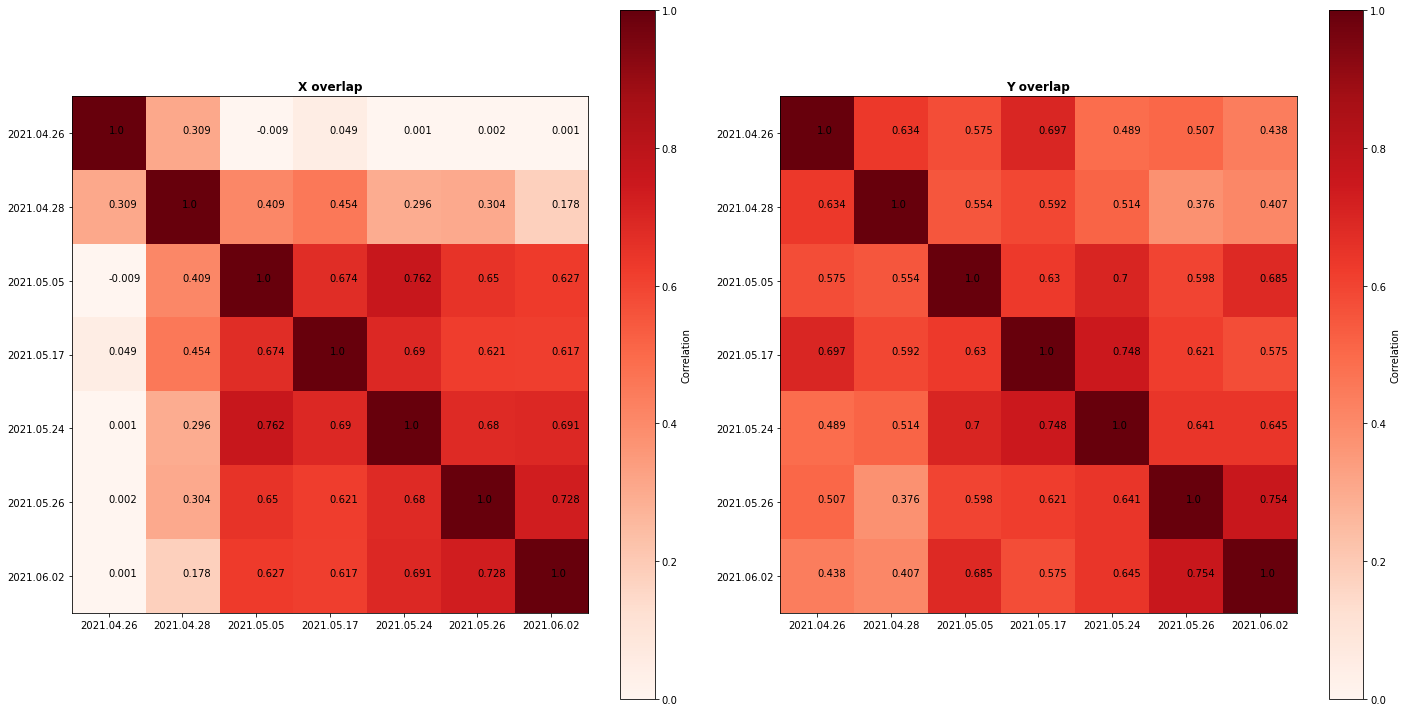

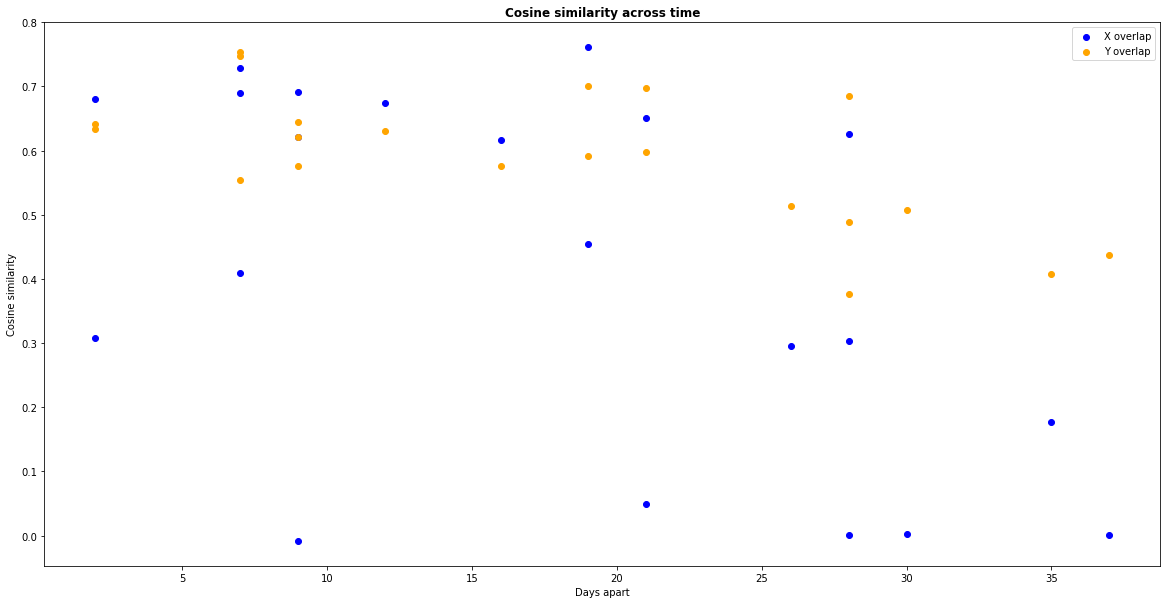

In [71]:
figSize(10, 20)


corrs  = np.zeros((nFiles, nFiles, 2))
diffs  = np.zeros((nFiles, nFiles))

for i in range(nFiles):
    for j in range(nFiles):
        diffs[i, j] = daysBetween(dates[i], dates[j])
        for k in range(2):
            corrs[i, j, k] = np.corrcoef(weights[i][k, :], weights[j][k, :])[0, 1]
            

labels = ['X overlap', 'Y overlap']
for k in range(2):
    plt.subplot(1, 2, k + 1)
    plt.imshow(corrs[:, :, k], cmap = 'Reds')
    for i in range(nFiles):
        for j in range(nFiles):
            plt.text(i, j, np.round(corrs[i, j, k], 3))

    bar = plt.colorbar()
    plt.title(labels[k], fontweight = 'bold')
    bar.set_label('Correlation')
    plt.clim([0, 1])
    ax = plt.gca()
    _ = ax.set_xticks(np.arange(nFiles) )
    _ = ax.set_xticklabels(dates)
    _ = ax.set_yticks(np.arange(nFiles) )
    _ = ax.set_yticklabels(dates)
    
plt.tight_layout()

plt.figure()
plt_dates = diffs[np.triu_indices(nFiles, k = 1)]
colors    = ['b', 'orange']
for k in range(2):
    plt_corrs = corrs[:, :, k][np.triu_indices(nFiles, k = 1)]
    plt.scatter(plt_dates, plt_corrs, c = colors[k], label = labels[k])
    
plt.legend()
plt.title('Cosine similarity across time', fontweight = 'bold')
plt.xlabel('Days apart')
plt.ylabel('Cosine similarity')

In [56]:
corrs[:, :, 0][np.triu_indices(nFiles, k = 1)]

(array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3,
        4, 4, 4, 5, 5, 6], dtype=int64),
 array([0, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 2, 3, 4, 5, 6, 3, 4, 5, 6,
        4, 5, 6, 5, 6, 6], dtype=int64))

array([ 0.30855562, -0.00860156,  0.0493744 ,  0.0013786 ,  0.0021837 ,
        0.00141343,  0.40903072,  0.45380329,  0.29550787,  0.30362744,
        0.17752636,  0.67392735,  0.76159011,  0.65016598,  0.62659103,
        0.69010398,  0.62054451,  0.61652145,  0.67980575,  0.69073827,
        0.72841247])